In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1pa4B0gfnoYPUtNSyDqPJRbZEprIC_fpP

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3
Downloading...
From (original): https://drive.google.com/uc?id=1pa4B0gfnoYPUtNSyDqPJRbZEprIC_fpP
From (redirected): https://drive.google.com/uc?id=1pa4B0gfnoYPUtNSyDqPJRbZEprIC_fpP&confirm=t&uuid=9b58f34d-80c9-4f0b-8326-a5fc39bd7bd3
To: /content/cityscapes_data.zip
100% 107M/107M [00:00<00:00, 110MB/s]


In [3]:
!unzip /content/cityscapes_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: cityscapes_data/train/506.jpg  
  inflating: __MACOSX/cityscapes_data/train/._506.jpg  
  inflating: cityscapes_data/train/260.jpg  
  inflating: __MACOSX/cityscapes_data/train/._260.jpg  
  inflating: cityscapes_data/train/274.jpg  
  inflating: __MACOSX/cityscapes_data/train/._274.jpg  
  inflating: cityscapes_data/train/1938.jpg  
  inflating: __MACOSX/cityscapes_data/train/._1938.jpg  
  inflating: cityscapes_data/train/512.jpg  
  inflating: __MACOSX/cityscapes_data/train/._512.jpg  
  inflating: cityscapes_data/train/1086.jpg  
  inflating: __MACOSX/cityscapes_data/train/._1086.jpg  
  inflating: cityscapes_data/train/2000.jpg  
  inflating: __MACOSX/cityscapes_data/train/._2000.jpg  
  inflating: cityscapes_data/train/1509.jpg  
  inflating: __MACOSX/cityscapes_data/train/._1509.jpg  
  inflating: cityscapes_data/train/923.jpg  
  inflating: __MACOSX/cityscapes_data/train/._923.jpg  
  inflating: cityscapes_data/tra

In [4]:
EPOCHS=10
BATCH_SIZE=10
HEIGHT=256
WIDTH=256
N_CLASSES=13

In [5]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)

    image = img[:,:256]
    mask = img[:,256:]

    return image, mask


def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

def getSegmentationArr(image, classes, width=WIDTH, height=HEIGHT):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

def give_color_to_seg_img(seg, n_classes=N_CLASSES):

    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

classes = 13

In [6]:
train_folder = "/content/cityscapes_data/train"
valid_folder = "/content/cityscapes_data/val"

num_of_training_samples = len(os.listdir(train_folder))
num_of_valid_samples = len(os.listdir(valid_folder))

def DataGenerator(path, batch_size=BATCH_SIZE, classes=N_CLASSES):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

In [7]:
train_gen = DataGenerator(train_folder, batch_size=BATCH_SIZE)
val_gen = DataGenerator(valid_folder, batch_size=BATCH_SIZE)

In [8]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

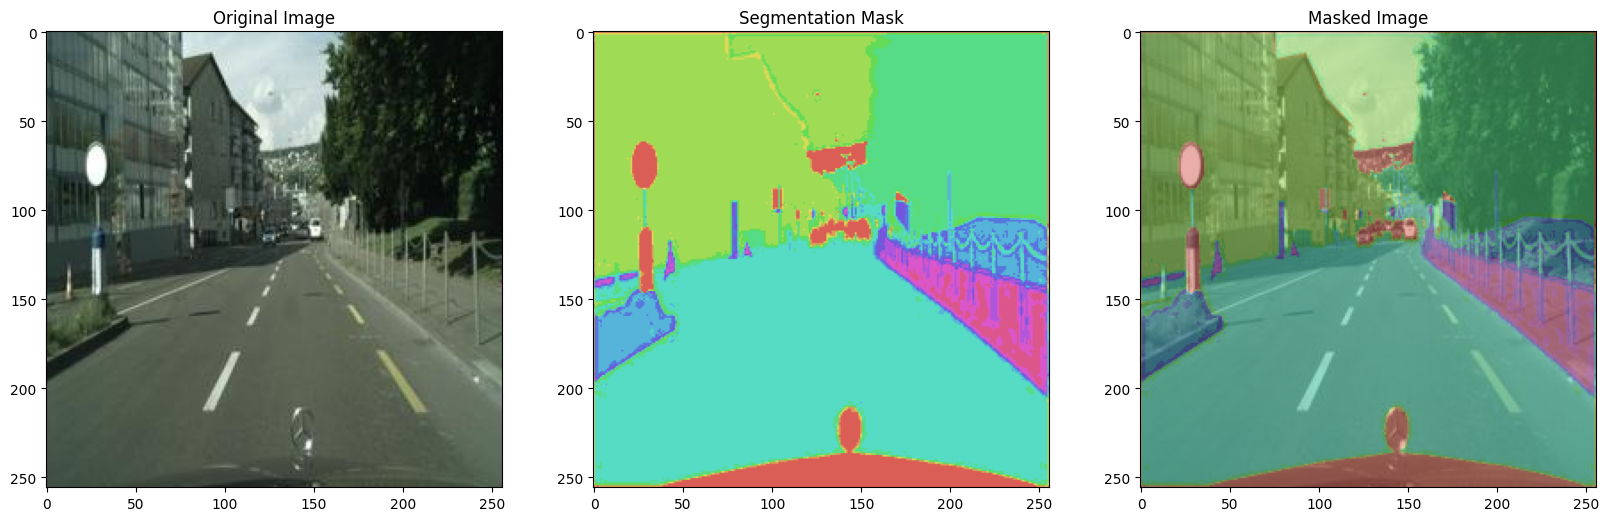

In [9]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
#predimg = cv2.addWeighted(imgs[i]/255, 0.6, _p, 0.4, 0)
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plt.show()

In [10]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((HEIGHT,WIDTH,3))

    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128

    outputs = Conv2D(13, (1, 1), padding="same", activation="sigmoid")(u4)
    model = Model(inputs, outputs)
    return model

In [11]:
checkpoint = ModelCheckpoint('seg_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [12]:
model = UNet()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [13]:
TRAIN_STEPS = num_of_training_samples//BATCH_SIZE+1
VAL_STEPS = num_of_valid_samples//BATCH_SIZE+1

history = model.fit_generator(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS,
                    validation_steps=VAL_STEPS, epochs=EPOCHS, callbacks = checkpoint)

<ipython-input-13-17660ee8ba66>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, validation_data=val_gen, steps_per_epoch=TRAIN_STEPS,


Epoch 1/10
298/298 [==============================] - ETA: 0s - loss: 1.5591 - acc: 0.5438
Epoch 1: val_acc improved from -inf to 0.67226, saving model to seg_model.hdf5
298/298 [==============================] - 95s 248ms/step - loss: 1.5591 - acc: 0.5438 - val_loss: 1.1960 - val_acc: 0.6723
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


298/298 [==============================] - ETA: 0s - loss: 1.0635 - acc: 0.7003
Epoch 2: val_acc improved from 0.67226 to 0.68319, saving model to seg_model.hdf5
298/298 [==============================] - 66s 222ms/step - loss: 1.0635 - acc: 0.7003 - val_loss: 1.1083 - val_acc: 0.6832
Epoch 3/10
298/298 [==============================] - ETA: 0s - loss: 0.9415 - acc: 0.7361
Epoch 3: val_acc improved from 0.68319 to 0.72795, saving model to seg_model.hdf5
298/298 [==============================] - 67s 226ms/step - loss: 0.9415 - acc: 0.7361 - val_loss: 0.9833 - val_acc: 0.7279
Epoch 4/10
298/298 [==============================] - ETA: 0s - loss: 0.8583 - acc: 0.7594
Epoch 4: val_acc improved from 0.72795 to 0.74201, saving model to seg_model.hdf5
298/298 [==============================] - 76s 255ms/step - loss: 0.8583 - acc: 0.7594 - val_loss: 0.8992 - val_acc: 0.7420
Epoch 5/10
298/298 [==============================] - ETA: 0s - loss: 0.8011 - acc: 0.7734
Epoch 5: val_acc improved fro

In [14]:
model.load_weights("./seg_model.hdf5")

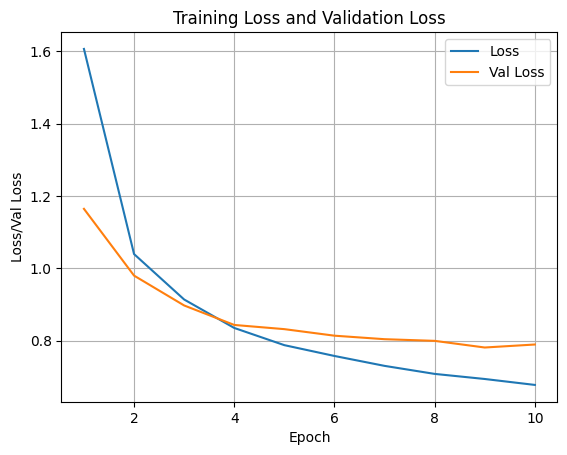

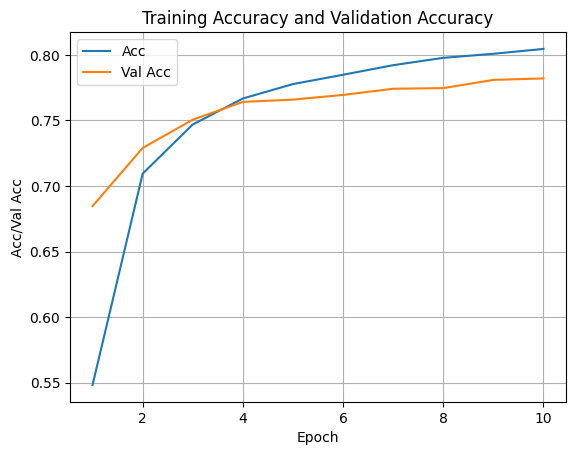

In [15]:
import matplotlib.pyplot as plt

# Extract data from the log
epochs = [1,2,3,4,5,6,7,8,9,10]

val_loss = [1.1645, 0.9798, 0.8972, 0.8433, 0.8317, 0.8136, 0.8039, 0.7993, 0.7809, 0.7892]
loss = [1.6069, 1.0394, 0.9137, 0.8350, 0.7874, 0.7575, 0.7301, 0.7079, 0.6938, 0.6774]
train_acc = [0.5483, 0.7094, 0.7469, 0.7667, 0.7777, 0.7848, 0.7921, 0.7977, 0.8008, 0.8045]
val_acc = [0.68465, 0.72898, 0.75056, 0.76411, 0.76585, 0.76942, 0.77413, 0.77463, 0.78088, 0.78200]

# ... (parsing logic to populate these lists)

# Plot loss and accuracy
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss/Val Loss')
plt.legend()
plt.grid(True)
plt.title('Training Loss and Validation Loss')
plt.show()

# Plot loss and accuracy
plt.plot(epochs, train_acc, label='Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc/Val Acc')
plt.legend()
plt.grid(True)
plt.title('Training Accuracy and Validation Accuracy')
plt.show()

1/1 [==============================] - 1s 559ms/step


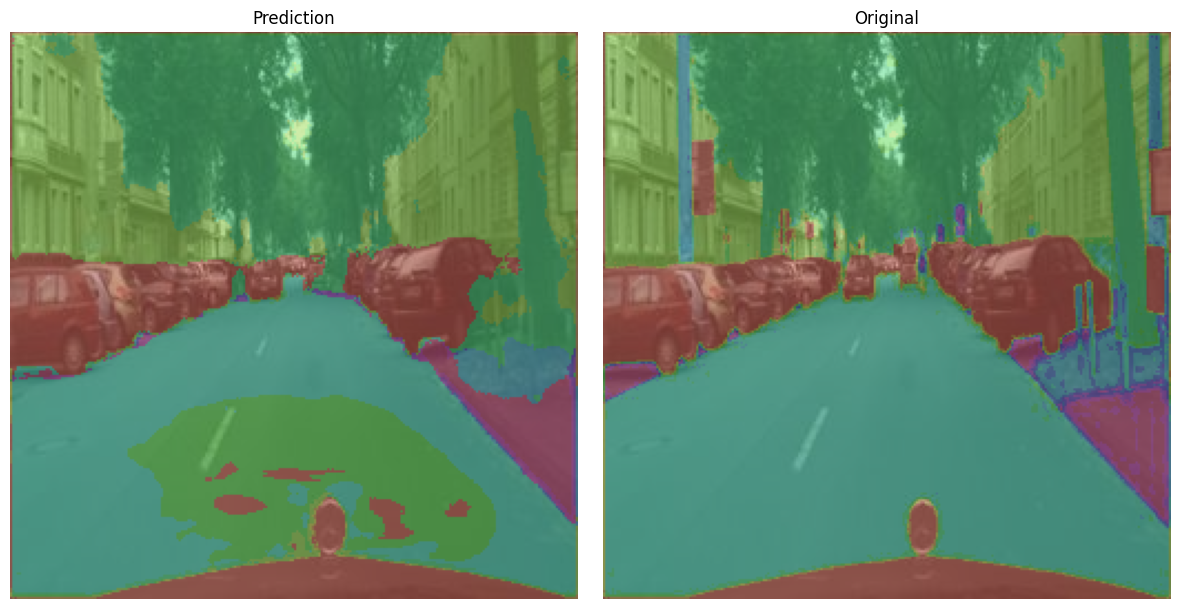

In [16]:
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    plt.subplot(122)
    plt.title("Original")
    plt.imshow(trueimg)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("pred_"+str(i)+".png", dpi=150)
    plt.show()